In [1]:
import math
import pandas_datareader as web
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import quandl
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
df = web.DataReader('FB', data_source='yahoo', start='2012-01-01', end='2020-04-15')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-05-18,45.000000,38.000000,42.049999,38.230000,573576400,38.230000
2012-05-21,36.660000,33.000000,36.529999,34.029999,168192700,34.029999
2012-05-22,33.590000,30.940001,32.610001,31.000000,101786600,31.000000
2012-05-23,32.500000,31.360001,31.370001,32.000000,73600000,32.000000
2012-05-24,33.209999,31.770000,32.950001,33.029999,50237200,33.029999


In [3]:
df.shape

(1989, 6)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


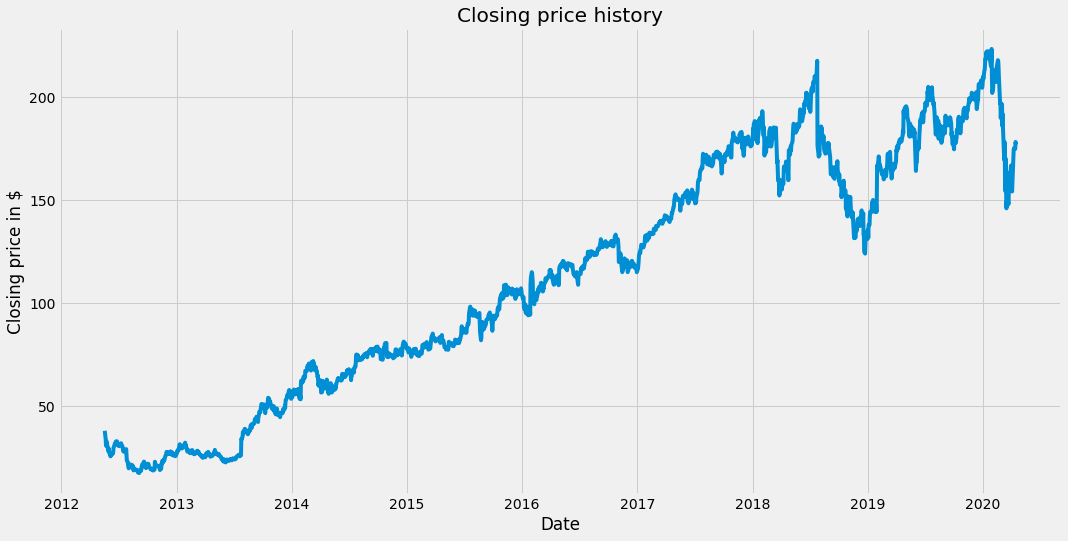

In [4]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16,8))
plt.title('Closing price history')
plt.plot(df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing price in $")
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)*0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data = scaled_data[0:training_data_len, :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1532, 60, 1)

In [6]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss= 'mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1532/1532 [==============================] - 70s 46ms/step - loss: 0.0015


In [7]:
test_data = scaled_data[training_data_len - 60: , :]

X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [8]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [9]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.29520967805415615

In [10]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions


/Users/azakeres/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


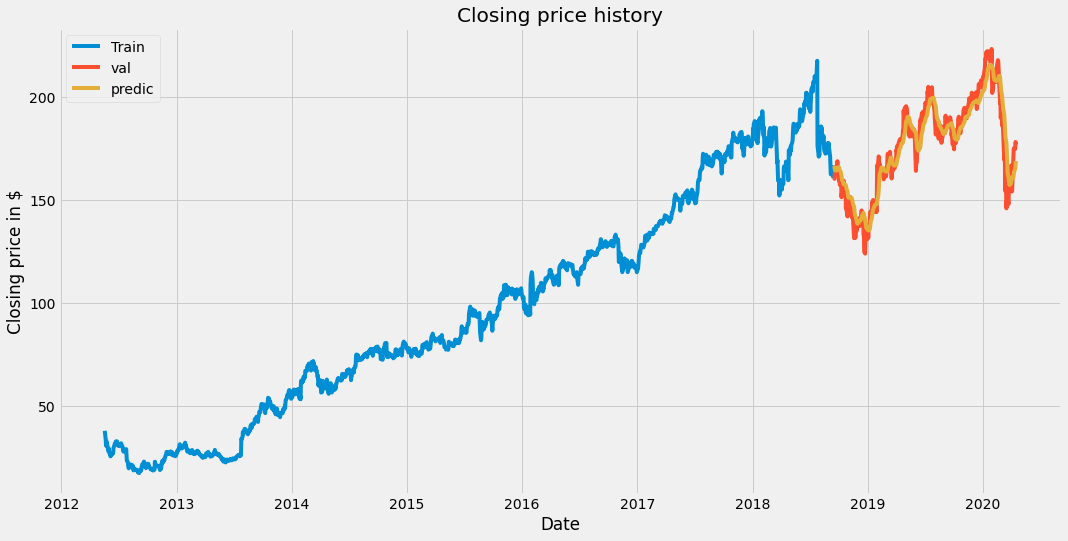

In [11]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16,8))
plt.title('Closing price history')
plt.plot(train['Close'])
plt.plot(valid[["Close","Predictions"]])
plt.xlabel("Date")
plt.ylabel("Closing price in $")
plt.legend(['Train', 'val', 'predic'])
plt.show()